In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
import pylab
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
df=pd.read_csv('/kaggle/input/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
df.shape

(891, 12)

# Feature Engineering

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Random Sample Imputation

In [6]:
df['Age_random']=df['Age']
random_sample=df['Age'].dropna().sample(df['Age'].isnull().sum(),random_state=0)
random_sample.index=df[df['Age'].isnull()].index
df.loc[df['Age'].isnull(),'Age_random']=random_sample

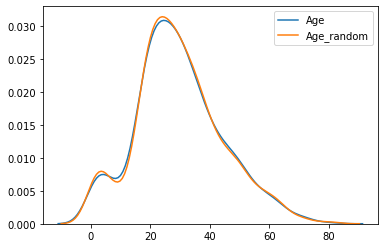

In [7]:
sns.kdeplot(df['Age'])
sns.kdeplot(df['Age_random'])

In [8]:
df.Cabin.fillna("Missing",inplace=True)

In [9]:
df.Cabin.unique()

array(['Missing', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62

In [10]:
df['Cabin']=df['Cabin'].astype(str).str[0]

In [11]:
df.groupby(['Cabin'])['Survived'].mean()

Cabin
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
M    0.299854
T    0.000000
Name: Survived, dtype: float64

Text(0, 0.5, 'Survived')

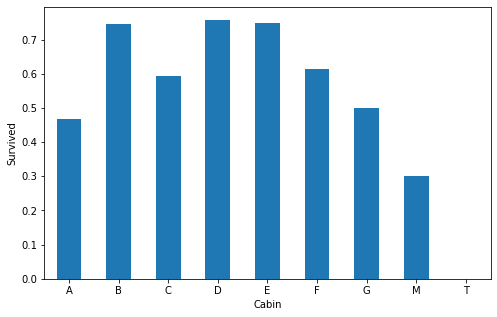

In [12]:
df.groupby(['Cabin'])['Survived'].mean().plot(kind='bar',figsize=(8,5),rot=0)
plt.ylabel('Survived')

# Target Guided Encoding

In [13]:
dic=df.groupby(['Cabin'])['Survived'].mean().sort_values().index
dic

Index(['T', 'M', 'A', 'G', 'C', 'F', 'B', 'E', 'D'], dtype='object', name='Cabin')

In [14]:
labels={j:i for i,j in enumerate(dic,0)}
labels

{'T': 0, 'M': 1, 'A': 2, 'G': 3, 'C': 4, 'F': 5, 'B': 6, 'E': 7, 'D': 8}

In [15]:
df['Cabin']=df['Cabin'].map(labels)

In [16]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_random
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,1,S,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,4,C,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,1,S,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,4,S,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,1,S,35.0


# Gaussian Transformation

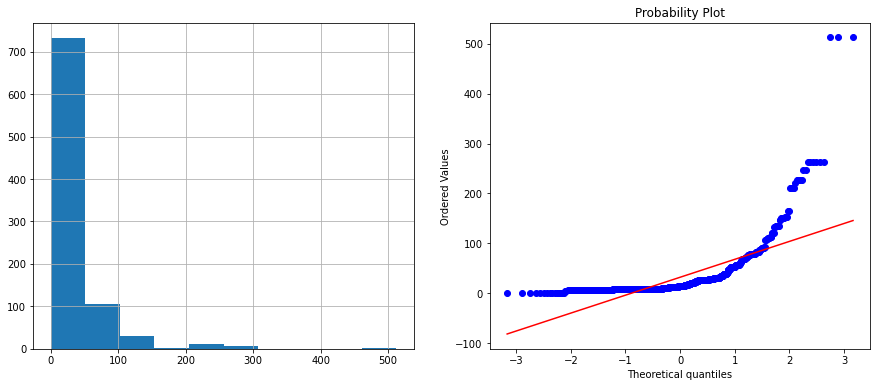

In [17]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
df['Fare'].hist()
plt.subplot(1,2,2)
stats.probplot(df['Fare'],dist="norm",plot=pylab)
plt.show()

In [18]:
df['Fare_log']=np.log(df['Fare']+1)

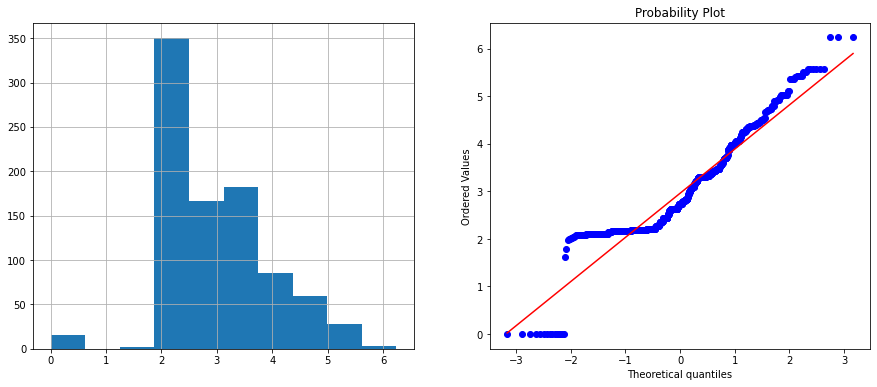

In [19]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
df['Fare_log'].hist()
plt.subplot(1,2,2)
stats.probplot(df['Fare_log'],dist="norm",plot=pylab)
plt.show()

In [20]:
df['Sex']=np.where(df['Sex']=='male',1,0)

# Frequency Encoding

In [21]:
em_mode=df['Embarked'].mode()
em_mode

0    S
dtype: object

In [22]:
df['Embarked'].fillna("S",inplace=True)

In [23]:
dic=df.Embarked.value_counts().to_dict()
dic

{'S': 646, 'C': 168, 'Q': 77}

In [24]:
df['Embarked']=df['Embarked'].map(dic)

In [25]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_random,Fare_log
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,1,646,22.0,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,4,168,38.0,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,1,646,26.0,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,4,646,35.0,3.990834
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,1,646,35.0,2.202765


Text(0, 0.5, 'Count')

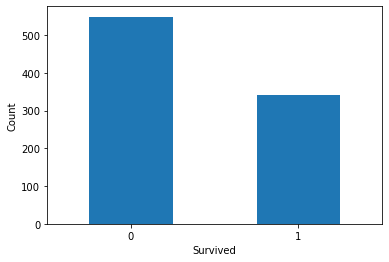

In [26]:
df.Survived.value_counts().plot(kind='bar',rot=0)
plt.xlabel('Survived')
plt.ylabel('Count')

In [27]:
X=df.drop(['Name','PassengerId','Ticket','Age','Survived'],axis=1)
y=df['Survived']

# Feature Selection

In [28]:
df.Pclass.unique()

array([3, 1, 2])

In [ ]:
sns.pairplot(df.drop(['Name','Age','PassengerId','Ticket','Fare'],axis=1),hue="Survived",diag_kind="hist")

In [30]:
smt=SelectKBest(score_func=chi2,k=8)

In [31]:
selectbest=smt.fit(X,y)

In [32]:
dfscores=pd.DataFrame(selectbest.scores_)
dfcolumns=pd.DataFrame(X.columns)

In [33]:
best_F=pd.concat([dfscores,dfcolumns],axis=1)
best_F.columns=['Score','Features']
best_F

,Score,Features
0,30.873699,Pclass
1,92.702447,Sex
2,2.581865,SibSp
3,10.097499,Parch
4,4518.319091,Fare
5,201.785125,Cabin
6,1805.110887,Embarked
7,12.565030,Age_random
8,30.699030,Fare_log


In [34]:
print(best_F.nlargest(7,"Score"))

         Score    Features
4  4518.319091        Fare
6  1805.110887    Embarked
5   201.785125       Cabin
1    92.702447         Sex
0    30.873699      Pclass
8    30.699030    Fare_log
7    12.565030  Age_random


In [35]:
X=X.drop(['SibSp'],axis=1)

In [36]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

In [37]:
 model1=LogisticRegression(max_iter=10000)

In [38]:
model1.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

In [39]:
y_pred1=model1.predict(X_test)

In [74]:
cf=confusion_matrix(y_test,y_pred1)
cf

array([[93, 17],
       [16, 53]])

Text(42.0, 0.5, 'Predicted Label')

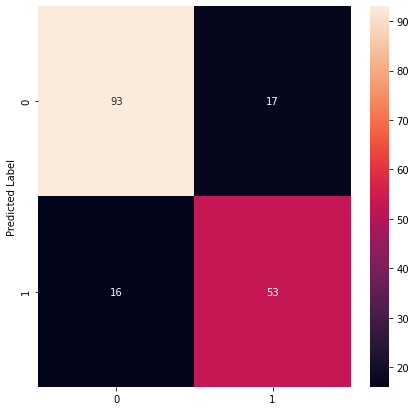

In [83]:
plt.figure(figsize=(7,7))
sns.heatmap(cf,annot=True)
plt.ylabel('Actual Label')
plt.ylabel('Predicted Label')

In [41]:
accuracy_score(y_test,y_pred1)

0.8156424581005587

In [65]:
cvs=cross_val_score(model1,X_train,y_train,cv=10)
cvs

array([0.79166667, 0.72222222, 0.83098592, 0.81690141, 0.74647887,
       0.74647887, 0.8028169 , 0.8028169 , 0.84507042, 0.8028169 ])

In [66]:
cvs.mean()

0.7908255086071987

In [67]:
model2=RandomForestClassifier(n_estimators=9)

In [68]:
model2.fit(X_train,y_train)

RandomForestClassifier(n_estimators=9)

In [69]:
y_pred2=model2.predict(X_test)

In [81]:
cf2=confusion_matrix(y_test,y_pred2)
cf2

array([[99, 11],
       [21, 48]])

Text(42.0, 0.5, 'Predicted Label')

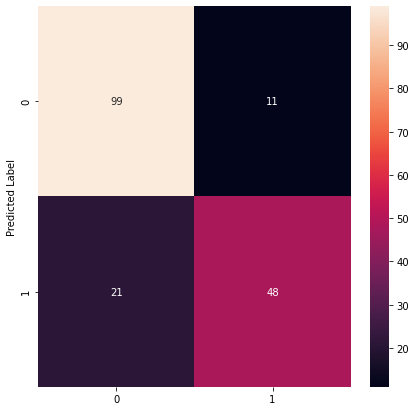

In [82]:
plt.figure(figsize=(7,7))
sns.heatmap(cf2,annot=True)
plt.ylabel('Actual Label')
plt.ylabel('Predicted Label')

In [71]:
accuracy_score(y_test,y_pred2)

0.8212290502793296

In [72]:
cvs=cross_val_score(model2,X_train,y_train,cv=10)
cvs

array([0.75      , 0.80555556, 0.81690141, 0.73239437, 0.8028169 ,
       0.77464789, 0.81690141, 0.78873239, 0.74647887, 0.8028169 ])

In [73]:
cvs.mean()

0.7837245696400628